## Deep Learning Food-Classification

Download the dataset fronm a zip file which has 11 categories of food.

In [1]:
from zipfile import ZipFile
with ZipFile('/home/workspace/dog-project/food11.zip', 'r') as zf:
    zf.extractall('/home/workspace/dog-project/')

### Importing the packages

In [4]:
% matplotlib inline
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from keras.utils.io_utils import HDF5Matrix

import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Flatten, Dense, Dropout, Activation, Input
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer


from keras.applications import VGG16

from keras.preprocessing import image

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as img

from scipy.misc import imresize

%matplotlib inline

from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict


#### Thought pooling would help in picking up some time.So using multiprocessing.

In [6]:
import multiprocessing as mp

num_processes = 6
pool = mp.Pool(processes=num_processes)

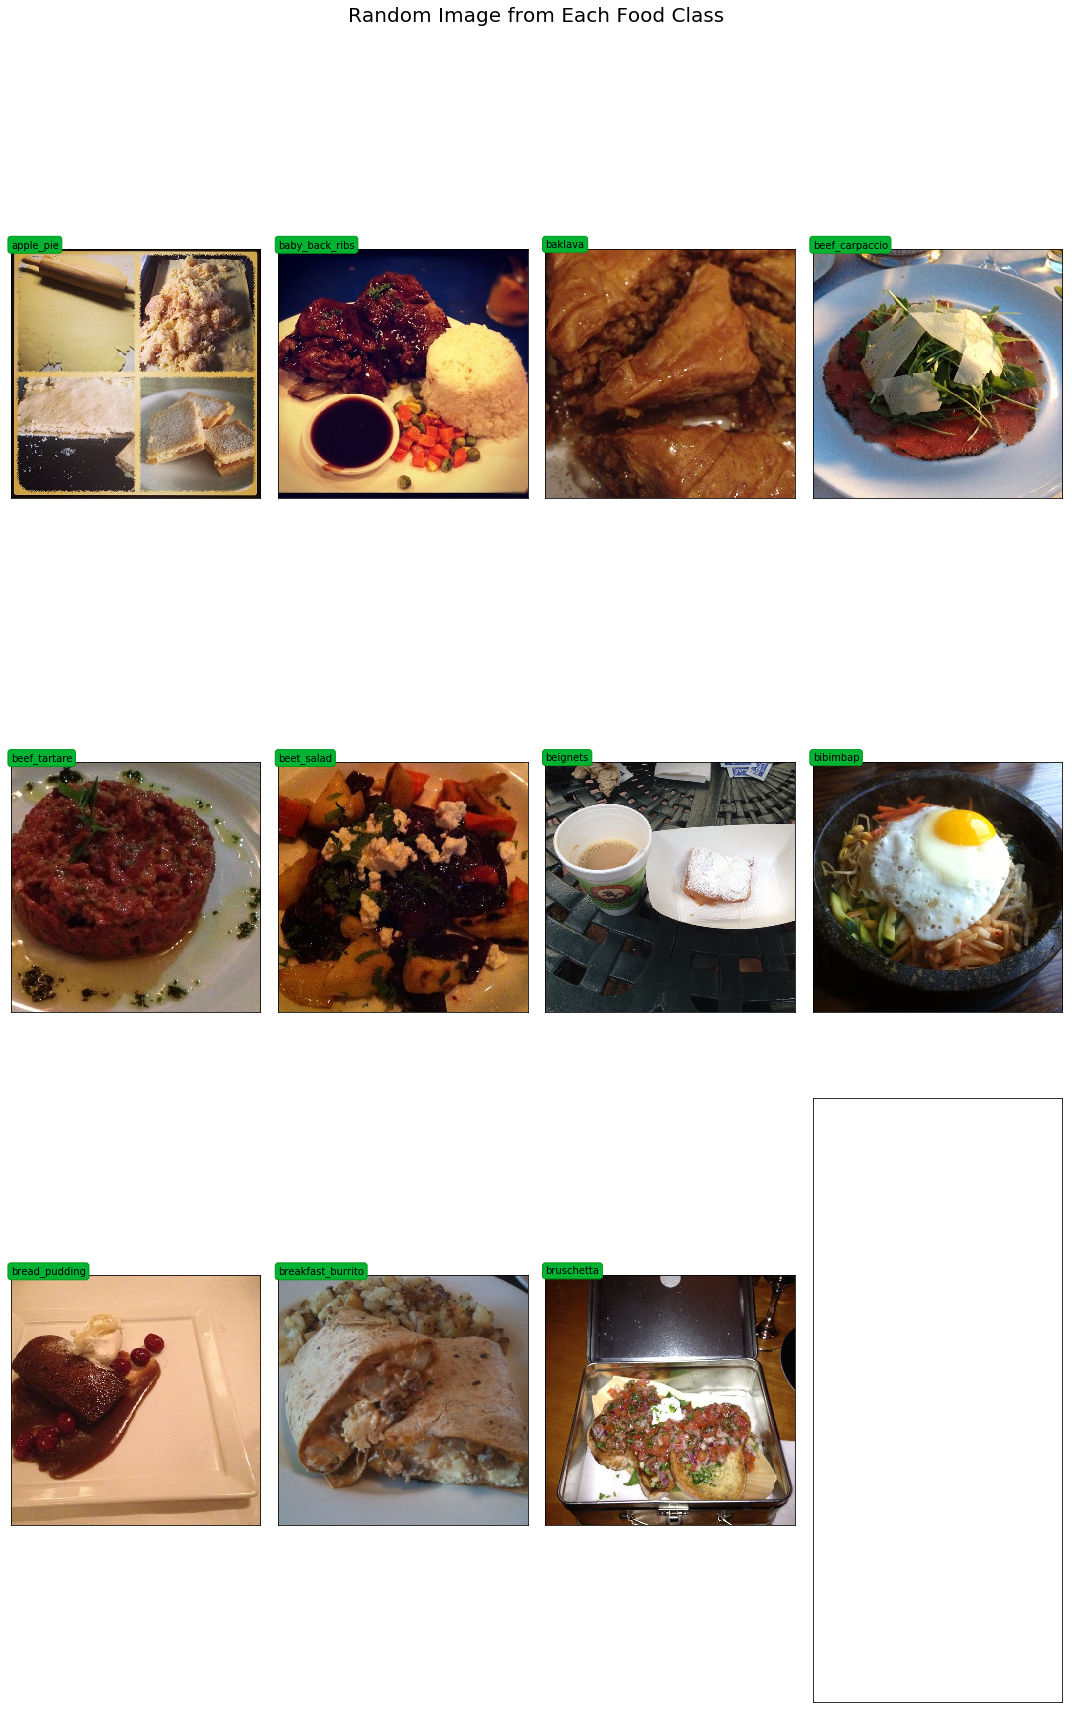

In [7]:
root_dir = './train_sub/'
rows = 3
cols = 4
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [10]:
from keras import applications
import math
from keras.utils.np_utils import to_categorical  
from keras import backend as K


#### Loading the traon,validation and test datasets and convering labels into one-hot encoded. 

In [21]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path,shuffle=False)
    food_files = np.array(data['filenames'])
    food_targets = np_utils.to_categorical(np.array(data['target']), 11)
    return food_files, food_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('./train_sub/')
valid_files, valid_targets = load_dataset('./val_sub/')
test_files, test_targets = load_dataset('./test_sub/')

# load list of food names
food_names = [item[12:-1] for item in sorted(glob("./train_sub/*/"))]


# print statistics about the dataset
print('There are %d total food categories.' % len(food_names))
print('There are %s total food images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training food images.' % len(train_files))
print('There are %d validation food images.' % len(valid_files))
print('There are %d test food images.'% len(test_files))



There are 11 total food categories.
There are 10999 total food images.

There are 7235 training food images.
There are 1014 validation food images.
There are 2750 test food images.


###Exploratory analysis seeing the distribution of adta for each class.

(0, 10)

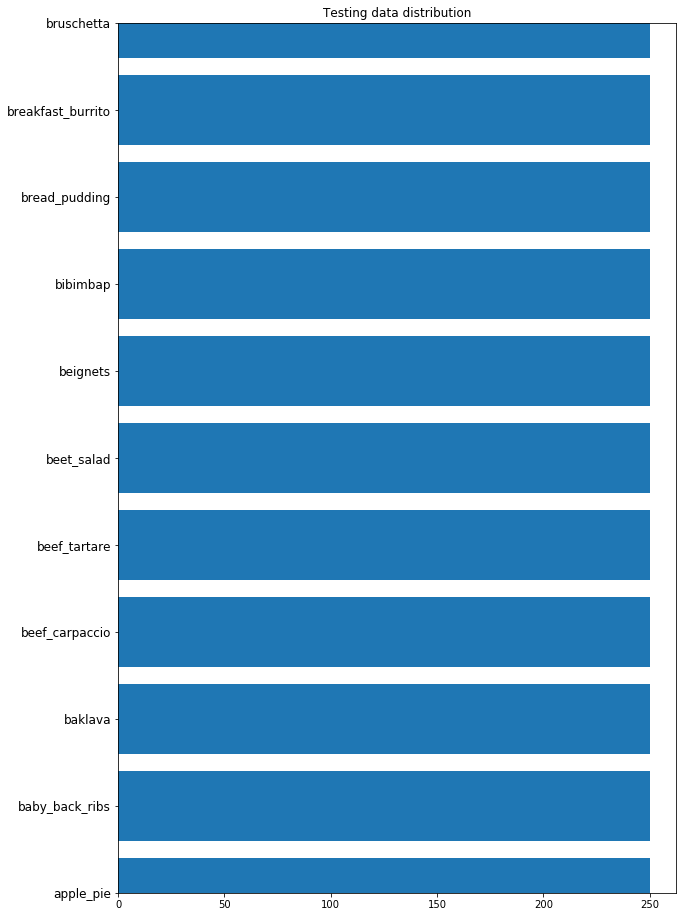

In [56]:
fig, (ax1) = plt.subplots(1, 1, figsize = (10, 16))
plt.title('Testing data distribution')  
v_sum = np.sum(test_targets, 0)
x_coord = np.arange(test_targets.shape[1])
ax1.barh(x_coord, v_sum)
out_ticks = [(c_x, c_label) for c_sum, c_x, c_label in zip(v_sum, x_coord, food_names) if c_sum>0]
ax1.set_yticks([c_x for c_x, c_label in out_ticks])
_ = ax1.set_yticklabels([c_label for c_x, c_label in out_ticks], rotation=0, fontsize = 12)
ax1.set_ylim(0, x_coord.max())

#### Setting the hyper parameters and getting data directly from directory.

In [25]:
#models_filename = 'weights.best.hdf5'
image_dir_train = './train_sub/'
image_dir_test = './test_sub/'
image_dir_val = './val_sub/'

#nb_train_samples = 7235
#nb_validation_samples = 1014

image_size = (224, 224)
batch_size = 16
epochs = 20
#n_classes=11



So I used this feature in Keras for preprocessing and augmenting the images.ImageDataGenerator has few parameters to play with the  data augumentaion.Will just check one of them with horizontal_flip = True.I've rescaled the values by dividing them by 255.The train_generator functions takes imagegenertor and processes from the directory.Target the image size we want  from the generator.Batch size determines the the number of batches.

In [272]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.2,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=0)

train_generator = train_datagen.flow_from_directory(
image_dir_train,
target_size = (224, 224),### the image size we want  from the generator
batch_size = batch_size, 
class_mode = "categorical") ##As we would be using categorical one hot encoded labels 

nb_train_samples = len(train_generator.filenames)  
num_classes = len(train_generator.class_indices)  

val_datagen = ImageDataGenerator(rescale = 1./255)
    
    
    
    


val_generator = val_datagen.flow_from_directory(
        image_dir_val,
        target_size = (image_size[0], image_size[1]), 
        batch_size=batch_size,
        class_mode="categorical")
    
nb_validation_samples = len(val_generator.filenames)  
num_classes = len(val_generator.class_indices)  

predict_size_train = int(math.ceil(nb_train_samples / batch_size))  

test_datagen = ImageDataGenerator(rescale = 1./255)
    
    
test_generator = test_datagen.flow_from_directory(
        image_dir_test,
        target_size = (image_size[0], image_size[1]), 
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True)



Found 7235 images belonging to 11 classes.
Found 1014 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.


### Plotting few images to see what imagedatagenertor is producing.
### The distorted images when the horizontal flip is true

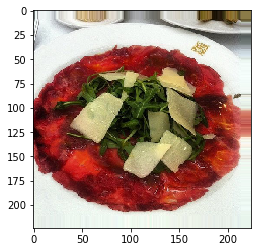

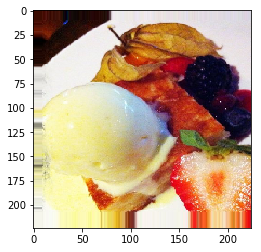

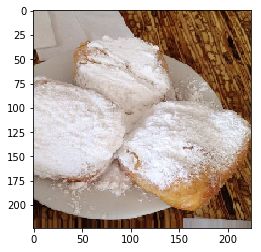

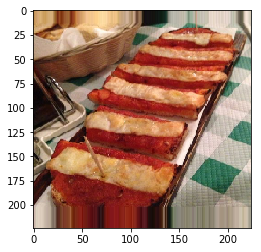

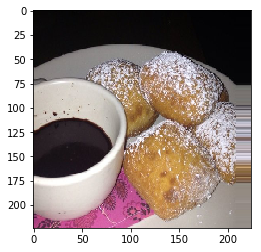

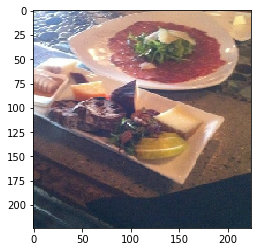

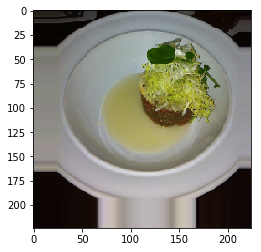

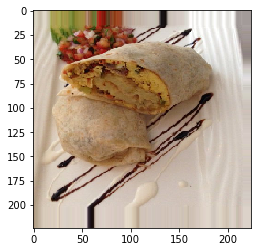

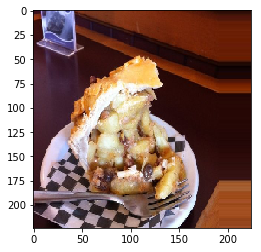

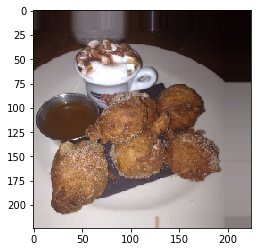

In [12]:
for n in range(10):
    _ = train_generator.next()
    image = (_[0][0]) # take the first image from the batch
    
    plt.imshow(image)
    plt.show()

### Build and Compile the Model

In [70]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, image_size[0], image_size[1])
else:
    input_shape = (image_size[0], image_size[1], 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(11))
model.add(Activation('sigmoid'))

model.compile(loss="categorical_crossentropy",
              optimizer='rmsprop',
              metrics=['accuracy'])

### Fully connected Model

In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
__________

### Fit the Model 

In [30]:
checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)


model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size,callbacks=[checkpointer], verbose=1)



Epoch 1/20
452/452 [==============================] - 107s 236ms/step - loss: 1.7601 - acc: 0.4023 - val_loss: 1.7505 - val_acc: 0.3790
Epoch 2/20
452/452 [==============================] - 105s 232ms/step - loss: 1.6470 - acc: 0.4422 - val_loss: 1.8071 - val_acc: 0.3829
Epoch 3/20
452/452 [==============================] - 105s 232ms/step - loss: 1.5748 - acc: 0.4616 - val_loss: 1.7044 - val_acc: 0.3938
Epoch 4/20
452/452 [==============================] - 105s 233ms/step - loss: 1.5140 - acc: 0.4795 - val_loss: 1.5368 - val_acc: 0.4812
Epoch 5/20
452/452 [==============================] - 104s 230ms/step - loss: 1.4938 - acc: 0.4869 - val_loss: 1.5796 - val_acc: 0.4841
Epoch 6/20
452/452 [==============================] - 105s 233ms/step - loss: 1.4491 - acc: 0.5010 - val_loss: 1.4429 - val_acc: 0.5020
Epoch 7/20
452/452 [==============================] - 105s 232ms/step - loss: 1.4035 - acc: 0.5198 - val_loss: 1.7501 - val_acc: 0.4157
Epoch 8/20
452/452 [============================

### Evaluating the model for the loss and  accuracy for train data.

In [35]:
%%time

model.load_weights('weights.best.hdf5')

preds_test = model.evaluate_generator(test_generator, steps=300)
print("loss:",preds_test[0],"accuracy",preds_test[1])

loss: 1.33352278187 accuracy 0.552521884156
CPU times: user 33.2 s, sys: 1.4 s, total: 34.6 s
Wall time: 31.2 s


Obtaining the bottleneck features using image data generator with VGG16 pretrained on imagenet.The files are saved as .npy and this part of code of obtaining bottleneck fetaures was executed in GPU.

In [36]:
def save_bottlebeck_features():
    train_datagen = ImageDataGenerator(rescale = 1./255)


    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    #Save Bottleneck fetures for training data
    generator = train_datagen.flow_from_directory(
        image_dir_train,
        target_size = (image_size[0], image_size[1]), 
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    nb_train_samples = len(generator.filenames)  
    num_classes = len(generator.class_indices)  
   
    predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
    
    bottleneck_features_train = model.predict_generator(
        generator,predict_size_train)
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)
    
    #Save Bottleneck fetures for validation data


    val_datagen = ImageDataGenerator(rescale = 1./255)
    val_generator = val_datagen.flow_from_directory(
        image_dir_val,
        target_size = (image_size[0], image_size[1]), 
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    nb_validation_samples = len(val_generator.filenames)  
    num_classes = len(val_generator.class_indices)  
   
    predict_size_val = int(math.ceil(nb_validation_samples / batch_size))  
    
    
    bottleneck_features_validation = model.predict_generator(
        generator_1, predict_size_val)
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)
    
#Save Bottleneck fetures for testing data


    test_datagen = ImageDataGenerator(rescale = 1./255)
    generator_2 = test_datagen.flow_from_directory(
        image_dir_test,
        target_size = (image_size[0], image_size[1]), 
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False)
    
    nb_test_samples= len(generator_2.filenames)  
    num_classes = len(generator_2.class_indices)  
   
    predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
    
    
    bottleneck_features_test = model.predict_generator(
        generator_2, predict_size_test)
    np.save(open('bottleneck_features_test.npy', 'wb'),
            bottleneck_features_test)

save_bottlebeck_features()

Found 7235 images belonging to 11 classes.
Found 1014 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.


### Loading the obtained bottleneck features.

In [13]:
train_VGG16 = np.load(open('bottleneck_features_train.npy','rb'))
valid_VGG16=np.load(open('bottleneck_features_validation.npy','rb'))
test_VGG16=np.load(open('bottleneck_features_test.npy','rb'))

In [14]:
##checking the shape of the data from bottleneck
print(train_VGG16.shape)
print(valid_VGG16.shape)
print(test_VGG16.shape)

(7235, 7, 7, 512)
(1014, 7, 7, 512)
(2750, 7, 7, 512)


In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

### Adding the bottom layer.The fully connected layer looks like this.

In [16]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dropout(0.5))
VGG16_model.add(Dense(11, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                5643      
Total params: 5,643.0
Trainable params: 5,643.0
Non-trainable params: 0.0
_________________________________________________________________


### Build and Compile the Model

In [17]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [27]:
checkpointer = ModelCheckpoint(filepath='weights.best.VGG16_1.hdf5', 
                               verbose=1, save_best_only=True)

history=VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=50, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 7235 samples, validate on 1014 samples
Epoch 1/50
7235/7235 [==============================] - 1s - loss: 1.5988 - acc: 0.4560 - val_loss: 1.5291 - val_acc: 0.5108
Epoch 2/50
7235/7235 [==============================] - 2s - loss: 1.5935 - acc: 0.4614 - val_loss: 1.5355 - val_acc: 0.4892
Epoch 3/50
7235/7235 [==============================] - 2s - loss: 1.5826 - acc: 0.4557 - val_loss: 1.5199 - val_acc: 0.5059
Epoch 4/50
7235/7235 [==============================] - 2s - loss: 1.5922 - acc: 0.4569 - val_loss: 1.5308 - val_acc: 0.5049
Epoch 5/50
7235/7235 [==============================] - 2s - loss: 1.5875 - acc: 0.4589 - val_loss: 1.5396 - val_acc: 0.4931
Epoch 6/50
7235/7235 [==============================] - 1s - loss: 1.5809 - acc: 0.4645 - val_loss: 1.5166 - val_acc: 0.5059
Epoch 7/50
7235/7235 [==============================] - 2s - loss: 1.5783 - acc: 0.4658 - val_loss: 1.5229 - val_acc: 0.5030
Epoch 8/50
7235/7235 [==============================] - 1s - loss: 1.5822 - a

### Load the best weights from the Model.

In [28]:
VGG16_model.load_weights('weights.best.VGG16_1.hdf5')

### Predict the Model and evaluate the test accuracy.

In [29]:
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 57.0545%


Let us try to improve the accuracy by adding an extra dense layer.Let us add a dense layer and relu activation.We will follow the previous steps of compiling and fitting the model.

In [30]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
#Added a dense layer with relu activation
VGG16_model.add(Dense(256, activation="relu"))
VGG16_model.add(Dropout(0.5))
VGG16_model.add(Dense(11, activation='softmax'))

VGG16_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)                2827      
Total params: 134,155.0
Trainable params: 134,155.0
Non-trainable params: 0.0
_________________________________________________________________


In [32]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='weights.best.VGG16_2.hdf5', 
                               verbose=1, save_best_only=True)

history=VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=50, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 7235 samples, validate on 1014 samples
Epoch 1/50
7235/7235 [==============================] - 6s - loss: 2.1014 - acc: 0.2626 - val_loss: 1.8345 - val_acc: 0.4004
Epoch 2/50
7235/7235 [==============================] - 3s - loss: 1.7615 - acc: 0.3964 - val_loss: 1.7067 - val_acc: 0.4181
Epoch 3/50
7235/7235 [==============================] - 3s - loss: 1.6248 - acc: 0.4390 - val_loss: 1.6176 - val_acc: 0.4625
Epoch 4/50
7235/7235 [==============================] - 4s - loss: 1.5393 - acc: 0.4746 - val_loss: 1.6732 - val_acc: 0.4418
Epoch 5/50
7235/7235 [==============================] - 4s - loss: 1.4952 - acc: 0.4929 - val_loss: 1.5006 - val_acc: 0.4901
Epoch 6/50
7235/7235 [==============================] - 4s - loss: 1.4432 - acc: 0.5103 - val_loss: 1.4753 - val_acc: 0.5138
Epoch 7/50
7235/7235 [==============================] - 4s - loss: 1.4194 - acc: 0.5149 - val_loss: 1.4526 - val_acc: 0.5020
Epoch 8/50
7235/7235 [==============================] - 4s - loss: 1.3802 - a

In [ ]:
### Now we will see how accuracy is doing.

In [33]:
VGG16_model.load_weights('weights.best.VGG16_2.hdf5')
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 61.7455%


##### Lets change the optimiser to 'adam'  and see if accuracy increases

In [34]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
checkpointer = ModelCheckpoint(filepath='weights.best.VGG16_3.hdf5', 
                               verbose=1, save_best_only=True)

history_adam=VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=50, batch_size=16, callbacks=[checkpointer], verbose=1)


Train on 7235 samples, validate on 1014 samples
Epoch 1/50
7235/7235 [==============================] - 4s - loss: 1.2484 - acc: 0.5804 - val_loss: 1.3394 - val_acc: 0.5523
Epoch 2/50
7235/7235 [==============================] - 4s - loss: 1.2281 - acc: 0.5808 - val_loss: 1.3801 - val_acc: 0.5464
Epoch 3/50
7235/7235 [==============================] - 4s - loss: 1.2160 - acc: 0.5849 - val_loss: 1.3515 - val_acc: 0.5168
Epoch 4/50
7235/7235 [==============================] - 3s - loss: 1.2012 - acc: 0.5895 - val_loss: 1.3581 - val_acc: 0.5493
Epoch 5/50
7235/7235 [==============================] - 3s - loss: 1.1849 - acc: 0.5961 - val_loss: 1.3313 - val_acc: 0.5641
Epoch 6/50
7235/7235 [==============================] - 3s - loss: 1.1814 - acc: 0.5950 - val_loss: 1.3673 - val_acc: 0.5582
Epoch 7/50
7235/7235 [==============================] - 3s - loss: 1.1636 - acc: 0.5975 - val_loss: 1.3619 - val_acc: 0.5533
Epoch 8/50
7235/7235 [==============================] - 4s - loss: 1.1404 - a

In [301]:
VGG16_model.load_weights('weights.best.VGG16_3.hdf5')


VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]
#print(VGG16_predictions)
# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 63.4182%


The accuracy increased by changing to the adam optimiser.Let us continue to extract features and predict few images downloaded from internet.

### Check How amny times  each class ocuured in the prediction

In [309]:
from collections import Counter
mylist = np.array(VGG16_predictions)
num_count = {}
for element in mylist:
    if not element in num_count:
        num_count[element] = 0
    num_count[element] = num_count[element] + 1
max_count = 0
max_count_element = -1
for k,v in num_count.items():
    if v > max_count:
        max_count = v
        max_count_element = k
        class_dictionary = test_generator.class_indices
        inv_map = {m: n for n, m in class_dictionary.items()} 
    print(k,inv_map[k],v)
print(max_count_element)
class_dictionary = test_generator.class_indices
inv_map = {m: n for n, m in class_dictionary.items()} 
print("Maximum repeated class",inv_map[max_count_element])
print(max_count,"times")

0 apple_pie 180
1 baby_back_ribs 284
2 baklava 285
3 beef_carpaccio 232
4 beef_tartare 318
5 beet_salad 340
6 beignets 245
7 bibimbap 262
8 bread_pudding 240
9 breakfast_burrito 222
10 bruschetta 142
5
Maximum repeated class beet_salad
340 times


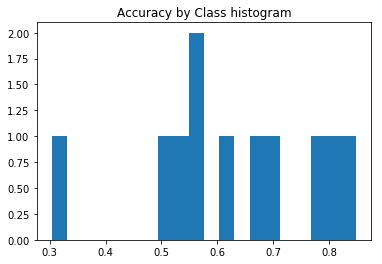

In [354]:
corrects = collections.defaultdict(int)
incorrects = collections.defaultdict(int)
for (pred, actual) in zip(np.array(VGG16_predictions), np.argmax(test_targets,axis=1)):
    if pred == actual:
        corrects[actual] += 1
    else:
        incorrects[actual] += 1

class_accuracies = {}
for ix in range(11):
    class_accuracies[ix] = corrects[ix]/250

plt.hist(list(class_accuracies.values()), bins=20)
plt.title('Accuracy by Class histogram')

In [355]:
sorted_class_accuracies = sorted(class_accuracies.items(), key=lambda x: -x[1])
class_names = [list(test_generator.class_indices)[i] for i in range(11)]

[(class_names[c[0]], c[1]) for c in sorted_class_accuracies]


[('beef_carpaccio', 0.848),
 ('beef_tartare', 0.8),
 ('beet_salad', 0.768),
 ('bread_pudding', 0.688),
 ('baby_back_ribs', 0.668),
 ('beignets', 0.608),
 ('breakfast_burrito', 0.576),
 ('apple_pie', 0.56),
 ('bruschetta', 0.548),
 ('bibimbap', 0.5),
 ('baklava', 0.304)]

### Calculate confusion matrix

Confusion matrix, without normalization
[[ 76   6  46   2   8   2  28   1  49  22  10]
 [  2 200   2   1   4   8   4   2  13   7   7]
 [  7   9 167   1   6   2  16   0  27  11   4]
 [  3   6   3 152   9  47   2   2   9   4  13]
 [  7   9   8  13 137  28   4   3  18   9  14]
 [  4  11   0  17  13 172   1   4  14   2  12]
 [  5   2  11   0   4   0 212   1   8   5   2]
 [  0  15   3   2   7  10   3 192   9   5   4]
 [ 15  21  11   1   7   5  17   4 140  22   7]
 [ 12  16  19   2   5   9  12   5  13 144  13]
 [  8  12   4  14  14  29   3   2  18  21 125]]


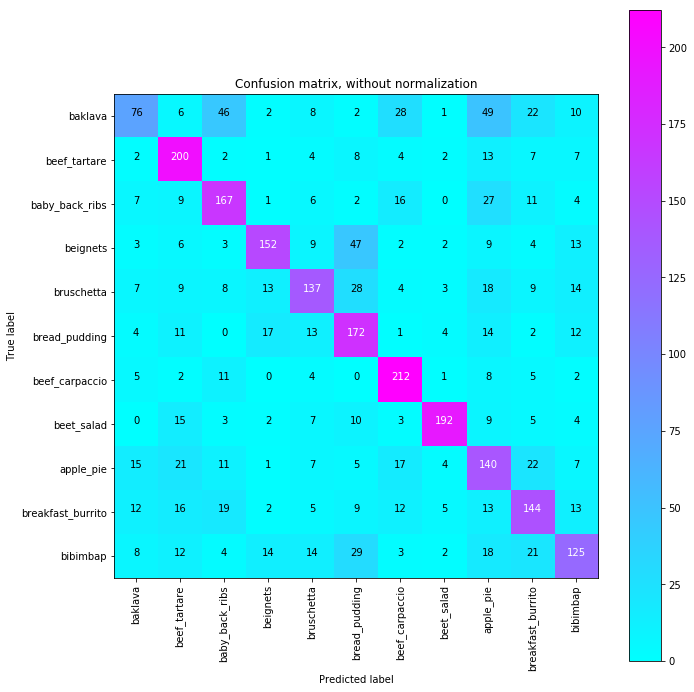

CPU times: user 1.36 s, sys: 412 ms, total: 1.78 s
Wall time: 2.19 s


In [379]:
%%time
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(test_targets, axis=1),np.array(VGG16_predictions))
np.set_printoptions(precision=2)

class_names = [list(test_generator.class_indices)[i] for i in range(11)]


plt.figure()
fig = plt.gcf()
fig.set_size_inches(10, 10)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.cool)
plt.show()

In [266]:
#image_path = 'test_images/fibaklava.jpg'
#image_path = 'test_images/bread_pudding.JPG'
#image_path = 'test_images/bfdownload.jpeg'
#image_path='test_images/Breakfast-Burritos.jpg'
def VGG16_predict_breed(img_path):

#image = plt.imread(img_path)
#print(pic)
    image=imresize(img_path, (224, 224))
    image = img_to_array(image)  
   
 # important! otherwise the predictions will be '0'  
    image = image/255  
   
    image = np.expand_dims(image, axis=0)
    model_new = applications.VGG16(include_top=False, weights='imagenet')  
   
 # get the bottleneck prediction from the pre-trained VGG16 model  
    bottleneck_prediction = model_new.predict(image)
    class_predicted = VGG16_model.predict_classes(bottleneck_prediction)  
   # print(class_predicted)
    inID = class_predicted[0]  
   
    class_dictionary = test_generator.class_indices 
   
    inv_map = {v: k for k, v in class_dictionary.items()}  
   
    label = inv_map[inID]
   # print("in",label)


    return label
 # get the prediction label  
    print(label)


In [191]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    #img = image.load_img(img_path, target_size=(224, 224))
    if (type(img_path) == type("s")):
        image_input = plt.imread(img_path)
        image_input = imresize(image_input, (224, 224))
        
        if(image_input.shape==(224, 224, 3)):
            print("yesy es")    

        # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
        x = (image.img_to_array(image_input))/255
        

        # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
        return np.expand_dims(x, axis=0)
    else:
        return np.expand_dims(img_path, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

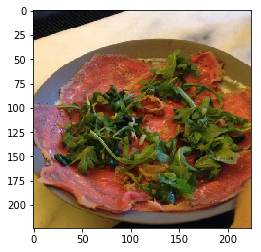

3
1/1 [==============================] - 0s
Actual image is:  beef_carpaccio

Model predicts its: beef_carpaccio


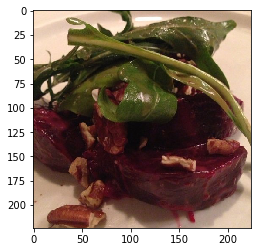

5
1/1 [==============================] - 0s
Actual image is:  beet_salad

Model predicts its: beet_salad


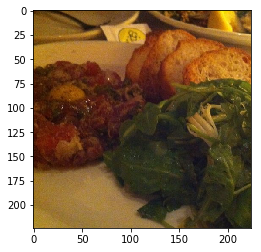

4
1/1 [==============================] - 0s
Actual image is:  beef_tartare

Model predicts its: beef_tartare


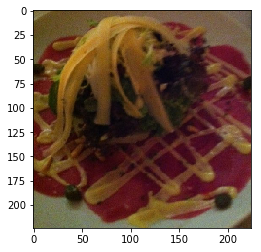

3
1/1 [==============================] - 0s
Actual image is:  beef_carpaccio

Model predicts its: beef_carpaccio


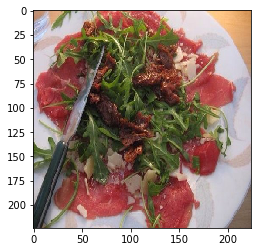

3
1/1 [==============================] - 0s
Actual image is:  beef_carpaccio

Model predicts its: beef_carpaccio


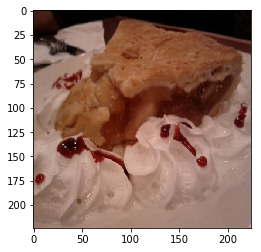

0
1/1 [==============================] - 0s
Actual image is:  apple_pie

Model predicts its: baklava


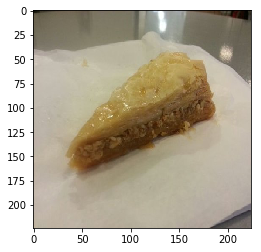

2
1/1 [==============================] - 0s
Actual image is:  baklava

Model predicts its: baklava


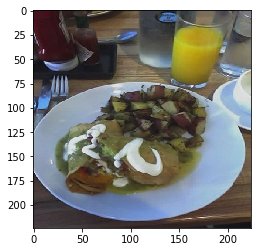

9
1/1 [==============================] - 0s
Actual image is:  breakfast_burrito

Model predicts its: beef_carpaccio


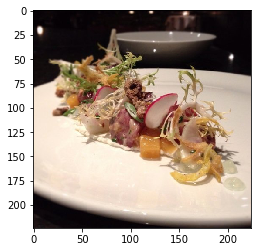

5
1/1 [==============================] - 0s
Actual image is:  beet_salad

Model predicts its: beet_salad


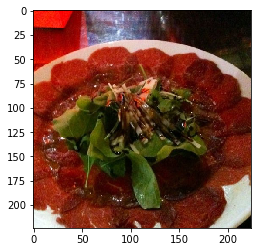

3
1/1 [==============================] - 0s
Actual image is:  beef_carpaccio

Model predicts its: beef_carpaccio


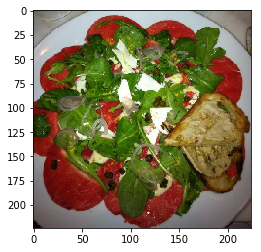

3
1/1 [==============================] - 0s
Actual image is:  beef_carpaccio

Model predicts its: beef_carpaccio


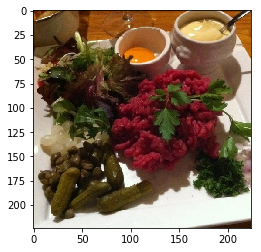

4
1/1 [==============================] - 0s
Actual image is:  beef_tartare

Model predicts its: beet_salad


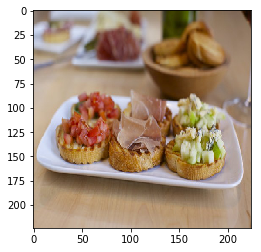

10
1/1 [==============================] - 0s
Actual image is:  bruschetta

Model predicts its: bruschetta


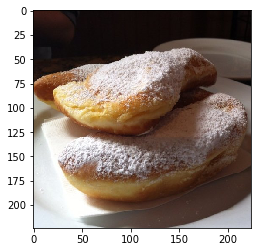

6
1/1 [==============================] - 0s
Actual image is:  beignets

Model predicts its: beignets


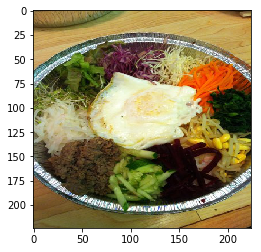

7
1/1 [==============================] - 0s
Actual image is:  bibimbap

Model predicts its: beet_salad


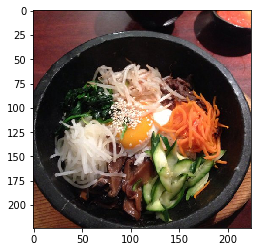

7
1/1 [==============================] - 0s
Actual image is:  bibimbap

Model predicts its: bibimbap


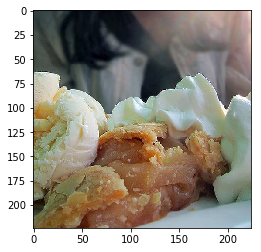

0
1/1 [==============================] - 0s
Actual image is:  apple_pie

Model predicts its: beignets


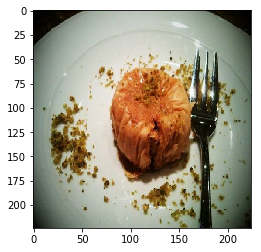

2
1/1 [==============================] - 0s
Actual image is:  baklava

Model predicts its: beef_tartare


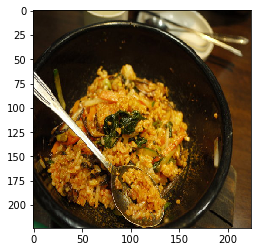

7
1/1 [==============================] - 0s
Actual image is:  bibimbap

Model predicts its: bibimbap


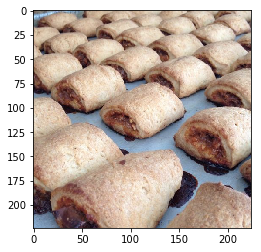

0
1/1 [==============================] - 0s
Actual image is:  apple_pie

Model predicts its: beignets


In [273]:
for n in range(20):
    _ = test_generator.next()
    image_test, classifier = (_[0][0],_[1][0]) # take the first image from the batch
    plt.imshow(image_test)
    plt.show()
    #print(classifier)
    index=np.argmax(classifier)
    print(index)
    class_dictionary = test_generator.class_indices
    inv_map = {v: k for k, v in class_dictionary.items()}  
    answer = inv_map[index]

   # predicted = np.argmax(VGG16_model.predict(extract_VGG16((np.array([image])))))
   # predicted=extract_VGG16(np.array(image_test))
    predict_1=VGG16_predict_breed(image_test)
    #print(predict_1)
  

    print('Actual image is: ', answer)
    print()
    print('Model predicts it''s:', predict_1)

In [ ]:
print(test_generator.class_indices)

### Lets check some random images downloaded from internet.

1/1 [==============================] - 0s
baklava


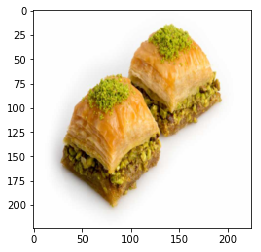

In [271]:
pic_path = 'test_images/fibaklava.jpg'
pic = plt.imread(pic_path)
#print(pic)
pic=imresize(pic, (224, 224))
predicted = VGG16_predict_breed(pic)
print(predicted)


#predicted_answer = list(test_generator.class_indices.keys())[predicted]
#print(predicted_answer)
plt.imshow(pic)

1/1 [==============================] - 14s
baklava


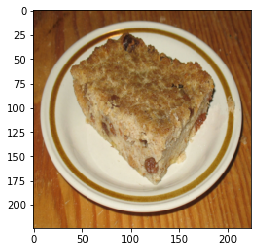

In [357]:
pic_path = 'test_images/bread_pudding.JPG'
pic = plt.imread(pic_path)
#print(pic)
pic=imresize(pic, (224, 224))
predicted = VGG16_predict_breed(pic)
print(predicted)


#predicted_answer = list(test_generator.class_indices.keys())[predicted]
#print(predicted_answer)
plt.imshow(pic)


Let us plot the train and validation accuracy and loss.

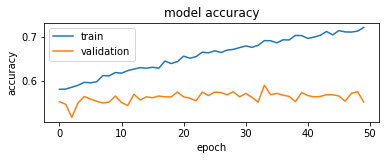

In [106]:
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history_adam.history['acc'])  
plt.plot(history_adam.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()

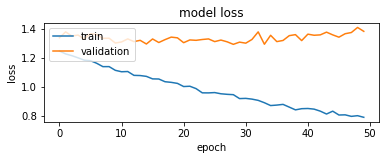

In [107]:
plt.subplot(212)  
plt.plot(history_adam.history['loss'])  
plt.plot(history_adam.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()  

### Conclusion

Future enhancements to the project would be developing a mobile app with deep learning and classify real pictures on the go.Transfer learning was very useful to complete my project on time.But would like to explore more real world problems and deep dive into Deep Learning like participating in data science hackathon and Kaggle competitions.



References:
    
https://pdfs.semanticscholar.org/9c1c/4e6ab238f34bef0348b04bfed78cda11e9ed.pdf

http://cs231n.stanford.edu/reports/2017/pdfs/19.pdf

https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model.